# Access data from the NECOFS (New England Coastal Ocean Forecast System) via OPeNDAP

Demonstration using the NetCDF4-Python library to access velocity data from a triangular grid ocean model (FVCOM) via OPeNDAP, specifying the desired URL, time, layer and lat/lon region of interest.  The resulting plot of forecast velocity vectors over color-shaded bathymetry is useful for a variety of recreational and scientific purposes. 

NECOFS (Northeastern Coastal Ocean Forecast System) is run by groups at the University of Massachusetts Dartmouth and the Woods Hole Oceanographic Institution, led by Drs. C. Chen, R. C. Beardsley, G. Cowles and B. Rothschild. Funding is provided to run the model by the NOAA-led Integrated Ocean Observing System and the State of Massachusetts.

NECOFS is a coupled numerical model that uses nested weather models, a coastal ocean circulation model, and a wave model. The ocean model is a volume-mesh model with horizontal resolution that is finer in complicated regions. It is layered (not depth-averaged) and includes the effects of tides, winds, and varying water densities caused by temperature and salinity changes.

* Model description: http://fvcom.smast.umassd.edu/research_projects/NECOFS/model_system.html
* THREDDS server with other forecast and archive products: http://www.smast.umassd.edu:8080/thredds/catalog.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as Tri
import netCDF4
import datetime as dt
import pandas as pd
%matplotlib inline

### Swim route.

In [2]:
lon_track=[-70.890150,  -70.927933,  -70.951417,  -70.976217,  -70.999150,  -71.034850]
lat_track=[ 42.327400,   42.316150,   42.314800,   42.309300,   42.322633,   42.328700]

### Dictionary with  model_name: OPeNDAP Data URL.

In [3]:
models = {'Massbay_forecast': 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc',
          'GOM3_Forecast': 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc',
          'Massbay_forecast_archive': 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/archives/necofs_mb',
          'GOM3_30_year_hindcast': 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/hindcasts/30yr_gom3'}

### DAP Data URL: MassBay GRID.

In [4]:
url = models['Massbay_forecast']

In [5]:
nc = netCDF4.Dataset(url)

nc.variables.keys()

odict_keys(['x', 'y', 'lon', 'lat', 'xc', 'yc', 'lonc', 'latc', 'siglay', 'h', 'nv', 'time', 'Times', 'zeta', 'nbe', 'aw0', 'awx', 'awy', 'u', 'v', 'ww', 'ua', 'va', 'temp', 'salinity', 'fvcom_mesh'])

### Rake a look at the "metadata" for the variable "u".

In [6]:
print(nc['temp'])

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, siglay, node)
    long_name: temperature
    standard_name: sea_water_potential_temperature
    units: degrees_C
    grid: fvcom_grid
    coordinates: time siglay lat lon
    type: data
    coverage_content_type: modelResult
    mesh: fvcom_mesh
    location: node
unlimited dimensions: time
current shape = (145, 10, 98432)
filling off



In [7]:
# Desired time for snapshot in UTC 
# ....right now (or some number of hours from now) ...
start = dt.datetime.utcnow() + dt.timedelta(hours=24)
# ... or specific time (UTC)    
#start = dt.datetime(2016,8,19,12,0)  #Note: EDT = UTC - 4 hours , EST = UTC -5 hours

In [8]:
# Get desired time step  
time_var = nc['time']
itime = netCDF4.date2index(start, time_var,select='nearest')

# Get lon,lat coordinates for nodes (depth)
lat = nc['lat'][:]
lon = nc['lon'][:]

# Get lon,lat coordinates for cell centers (depth)
latc = nc['latc'][:]
lonc = nc['lonc'][:]

# Get Connectivity array
nv = nc['nv'][:].T - 1

# Get depth
h = nc['h'][:]  # depth 

In [9]:
dtime = netCDF4.num2date(time_var[itime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print('Time in UTC:', daystr)

Time in UTC: 2016-Sep-10 18:00


In [10]:
tri = Tri.Triangulation(lon,lat, triangles=nv)
# get current at layer [0 = surface, -1 = bottom]
ilayer = 0

In [11]:
# long_island_sound
ax= [-74.05, -72.1, 40.75, 41.3] # region to plot
levels = np.arange(65.,80.,0.5)   # temperature contours to plot [48 to 65 in intervals of 1]
maxvel = 1.0 # velocity arrow scale
subsample = 10  # subsampling of velocity vectors

In [12]:
#boston light swim
levels = np.arange(64.,72.,1.)   # temperature contours to plot [48 to 65 in intervals of 1]
ax= [-71.05, -70.82, 42.28, 42.38] # region to plot
maxvel = 1.0 # velocity arrow scale
subsample = 3  # subsampling of velocity vectors

In [13]:
# find velocity points in bounding box
ind =  np.argwhere((lonc >= ax[0]) & (lonc <= ax[1]) & (latc >= ax[2]) & (latc <= ax[3]))

In [14]:
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

In [15]:
u = nc['u'][itime, ilayer, :]
v = nc['v'][itime, ilayer, :]

u = u*1.94  # convert m/s to knots
v = v*1.94  # convert m/s to knots

In [16]:
t = nc['temp'][itime,ilayer,:]
t = 32. + t*9./5.    #convert from C to F

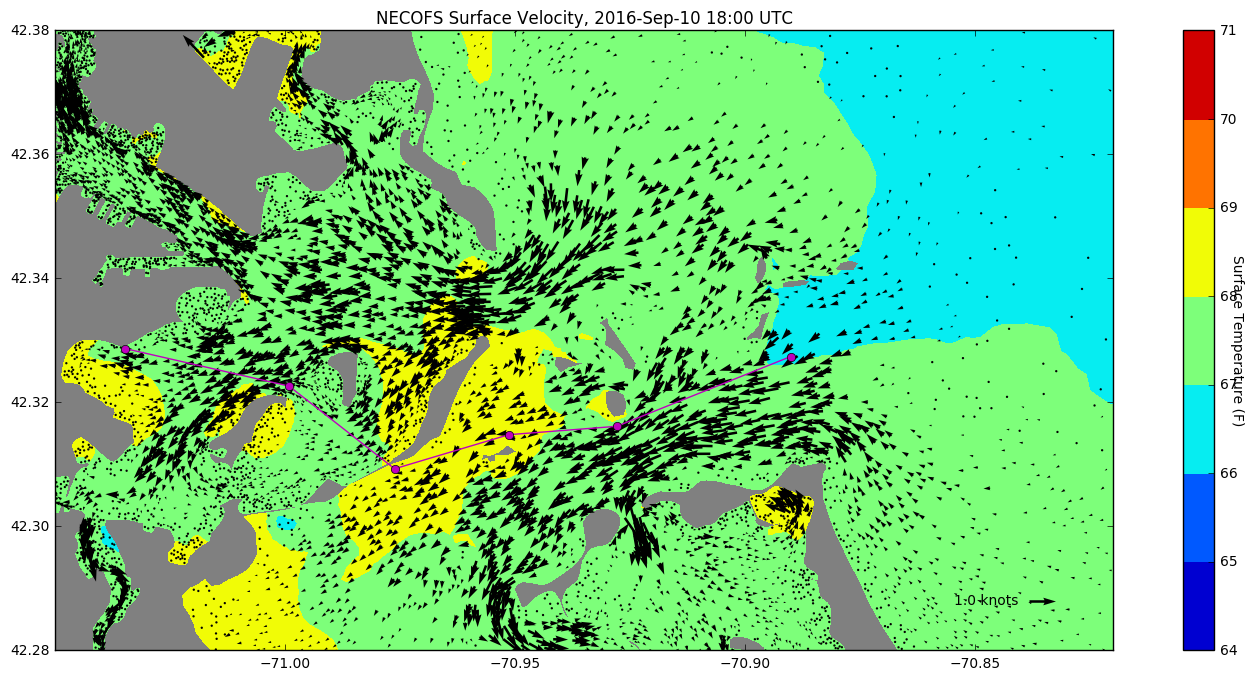

In [17]:
# tricontourf plot of water depth with vectors on top

plt.figure(figsize=(18,8))
plt.subplot(111,aspect=(1.0/np.cos(lat.mean()*np.pi/180.0)))
#tricontourf(tri, t,levels=levels,shading='faceted',cmap=plt.cm.gist_earth)
plt.tricontourf(tri, t,levels=levels,shading='faceted')
plt.axis(ax)
plt.gca().patch.set_facecolor('0.5')
cbar = plt.colorbar()
cbar.set_label('Surface Temperature (F)', rotation=-90)
Q = plt.quiver(lonc[idv],latc[idv],u[idv],v[idv],scale=40)
maxstr='%3.1f knots' % maxvel
qk = plt.quiverkey(Q,0.92,0.08,maxvel,maxstr,labelpos='W')
plt.title('NECOFS Surface Velocity, %s UTC' % (daystr))
plt.plot(lon_track,lat_track,'m-o');

In [18]:
t.min()

57.118301

In [19]:
t.max()

70.369949

In [20]:
h = - nc['h'][:] / .3042  # convert to feet
hlevels = np.arange(-100,5,5)

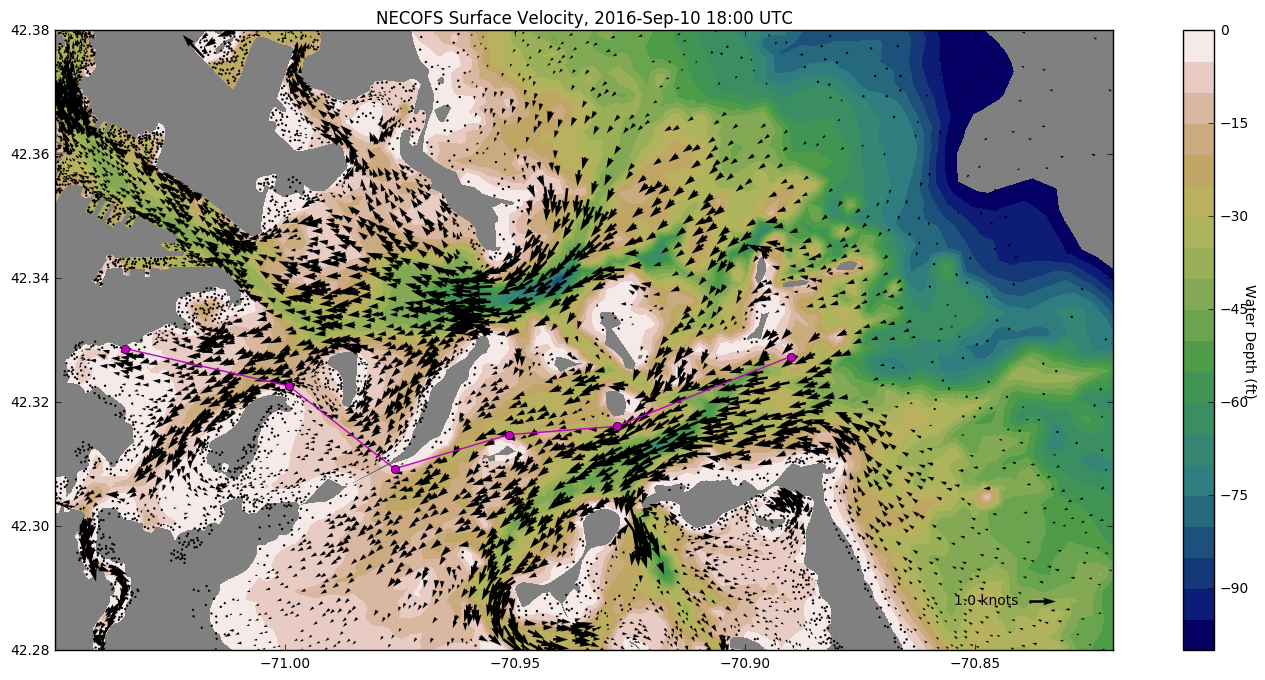

In [21]:
# tricontourf plot of water depth with vectors on top

plt.figure(figsize=(18,8))
plt.subplot(111,aspect=(1.0/np.cos(lat.mean()*np.pi/180.0)))
plt.tricontourf(tri, h,levels=hlevels,shading='faceted',cmap=plt.cm.gist_earth)
plt.axis(ax)
plt.gca().patch.set_facecolor('0.5')
cbar = plt.colorbar()
cbar.set_label('Water Depth (ft)', rotation=-90)
Q = plt.quiver(lonc[idv],latc[idv],u[idv],v[idv],scale=40)
maxstr='%3.1f knots' % maxvel
qk = plt.quiverkey(Q,0.92,0.08,maxvel,maxstr,labelpos='W')
plt.title('NECOFS Surface Velocity, %s UTC' % (daystr))
plt.plot(lon_track,lat_track,'m-o');